# Analiza glavnih komponenti za kategoričke podatke


Iliti na engleskom jeziku *Principal Components Analisys for Categorical Data*.


Svrha je ove bilježnice demonstracija kako koristiti klasu `RS_PCA` (iz skripte *script/rs_pca.py*) za analizu glavnih komponenti za kategoričke podatke.

Klasa implementira teoriju iskazanu u radu [*Covariance and PCA for Categorical Variables*](http://arxiv.org/abs/0711.4452) autora **Hirotaka Niitsuma** i **Takashi Okada** (2007.).

Autor: [Davor Penzar](mailto:davor.penzar@gmail.com).


In [1]:
##  PRIPREMA PYTHON OKRUZENJA

# IPython
from IPython import *
from IPython.display import *

# Standardna Python biblioteka
import copy
import functools
import math
import os
import random
import six
import string
import sys
import time
import warnings

# SciPy paketi
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym
from mpl_toolkits.mplot3d.axes3d import Axes3D

# Seaborn
import seaborn as sns

# Postavi prikaz grafova unutar biljeznice.
%matplotlib inline

# Postavi stil grafova na `ggplot'.
plt.style.use('ggplot')

# Inicijaliziraj ispis simbolickog racuna.
sym.init_printing()


In [2]:
# Vlastite skripte
from script.feature_engineering import *
from script.rs_pca import *
from script.timer import *


Učitajmo originalnu tablicu.


In [3]:
df = pd.read_pickle('../data/training_dataset_enc.pkl')


Za demonstraciju, koristit ćemo uzorak originalne tablice, a ne cijelu. Definirajmo stoga $ N \in \mathbb{N} $ za koji ćemo uzeti uzorak od $ N $ redaka iz originalne tablice.

**Napomena.** Metoda `RS_PCA.fit` *ignorira* retke s nedefiniranim vrijednostima (*NaN*). Naš izbor od $ N $ redaka ne znači da će rezultati biti bazirani na svih $ N $ redaka stoga je za $ N $ korisno uzeti dovoljno velik broj da udio onih redaka među njima koji imaju sve vrijednosti definirane bude također dovoljno velik.


In [4]:
N = 1000


Klasa `RS_PCA`, ako nije zadano koje stupce treba analizirati, sama prepoznaje kategoričke stupce (one čiji je `dtype` naziva `'category'` ili `'object'`). Za analzu glavnih komponenti pri pozivu metode `RS_PCA.fit` kao argument možemo dati nazive onih stupaca nad kojima želimo analizu, ali, budući da iz originalne tablice ionako ekstrahiramo samo $ N $ redaka, možemo odmah izbaciti i nepotrebne kategoričke stupce *KLIJENT_ID* i *OZNAKA_PARTIJE*.


In [5]:
df = df.sample(N)
df.drop(columns = ['KLIJENT_ID', 'OZNAKA_PARTIJE'], inplace = True)
df.reset_index(drop = True, inplace = True)


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
DATUM_IZVJESTAVANJA               1000 non-null datetime64[ns]
DATUM_OTVARANJA                   1000 non-null datetime64[ns]
PLANIRANI_DATUM_ZATVARANJA        927 non-null datetime64[ns]
DATUM_ZATVARANJA                  240 non-null datetime64[ns]
UGOVORENI_IZNOS                   1000 non-null float64
STANJE_NA_KRAJU_PRETH_KVARTALA    927 non-null float64
STANJE_NA_KRAJU_KVARTALA          1000 non-null float64
VALUTA                            1000 non-null category
VRSTA_KLIJENTA                    1000 non-null category
PROIZVOD                          1000 non-null category
VRSTA_PROIZVODA                   1000 non-null category
VISINA_KAMATE                     991 non-null float64
TIP_KAMATE                        1000 non-null category
STAROST                           1000 non-null int64
PRIJEVREMENI_RASKID               1000 non-null int64
dtypes: category(5), datetime

Promotrimo prvo dokumentaciju klase `RS_PCA`.


In [7]:
help(RS_PCA)


Help on class RS_PCA in module script.rs_pca:

class RS_PCA(builtins.object)
 |  Analiza glavnih komponenti koristeci regularne simplekse za kategoricke podatke.
 |  
 |  Acronyms
 |  --------
 |  RS
 |      Regular simplex; hrv. regularni simpleks.  Konveksna ljuska konacnog
 |      skupa tocaka u euklidskom prostoru tako da su radijvektori svake od tih
 |      tocaka norme 1 i da je kut izmedu svaka dva njihova radijvektora isti.
 |  
 |  LRSV
 |      List of regular simplex vertices; hrv. lista vrhova regularnih
 |      simpleksa. Za vektore koordinata vrhova regularnih simpleksa
 |          (v_{0, 0}, v_{0, 1}, ..., v_{0, n_0}),
 |          (v_{1, 0}, v_{1, 1}, ..., v_{1, n_1}),
 |          ...,
 |          (v_{m - 1, 0}, v_{m - 1, 1}, ..., v_{m - 1, n_{m - 1}})
 |      LRSV je njihova konkatenacija
 |          (v_{0, 0}, v_{0, 1}, ..., v_{0, n_0}), v_{1, 0}, v_{1, 1}, ...,
 |           v_{1, n_1}, ..., v_{m - 1, 0}, v_{m - 1, 1}, ...,
 |           v_{m - 1, n_{m - 1}}).
 |  
 |  R

In [8]:
if (
    input('Jeste li procitali dokumentaciju klase RS_PCA (da/ne)? ').upper() !=
    'DA'
):
    raise RuntimeError('Procitajte!')


Jeste li procitali dokumentaciju klase RS_PCA (da/ne)? da


U redu. Sada razumijemo kako koristiti tu klasu. Stoga, probajmo: inicijalizirat ćemo *RS-PCA*-analizator `pca`.


In [9]:
pca = RS_PCA()


Analizirajmo tablicu `df` (to jest, njezine retke koji ne sadrže nedefinirane vrijednosti (*NaN*) &mdash; vidi napomenu gore) pomoću `pca`. Mjerit ćemo i vrijeme da vidimo koliko je implementacija vremenski efikasna.

**Napomena.** Sve su metode u klasi `RS_PCA` implementirane isključivo sekvencijalno. Jedine eventualne paralelizacije koje se izvode prilikom poziva metoda klase `RS_PCA` su, vjerojatno, rezultat implementacije paketa *NumPy* odnosno njegovih funkcija koje se pozivaju u metodama klase `RS_PCA`.


In [10]:
t0 = time.time()

pca.fit(df)

t1 = time.time()

d = float(t1 - t0)

print(
    'Vrijeme racunanja: {h:d}h {m:02d}m {s:06.3f}s ({S:.3f}s)'.format(
        S = d, **hms_time(d)
    )
)

del t0
del t1
del d


Vrijeme racunanja: 0h 00m 00.360s (0.360s)


**Prijedlog.** Pročitajte dokumentaciju klase `RS_PCA`, točnije, njene metode `RS_PCA.fit`, da vidite koji su sve mogući opcionalni argumenti. Na iznimno velikim tablicama korisno je podešavati vrijednosti nekih argumenata.

Da bismo znali na koje se stupce što od atributa objekt `pca` odnosi, ispišimo `pca.columns`.


In [11]:
pca.columns


Index(['VALUTA', 'VRSTA_KLIJENTA', 'PROIZVOD', 'VRSTA_PROIZVODA',
       'TIP_KAMATE'],
      dtype='object')

Budući da nismo uzeli kompletnu originalnu tablicu `df` (prije uzimanja samo $ N $ redaka) pri pozivu metode `pca.fit`, provjerimo koje su kategoričke vrijednosti uopće pročitane za koji od navedenih stupaca. Kategorički nizovi dani su u istom poretku kao stupci kojima pripadaju u `pca.columns`.


In [12]:
pca.categories


(CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=False),
 CategoricalDtype(categories=[1110, 1120, 1320, 1410, 1420, 1430, 1510, 1550, 1610], ordered=False),
 CategoricalDtype(categories=['FD0100', 'FD0200', 'FL0801', 'FL0802', 'FL0803', 'FL0804',
                   'FL0900', 'FL1100', 'FL1200', 'FL1201', 'FL1202', 'FL1301',
                   'FL1304', 'FL1306', 'FL1309', 'FL1310', 'FL1400', 'FL1500',
                   'FL1600', 'TM0109'],
                  ordered=False),
 CategoricalDtype(categories=['A', 'L'], ordered=False),
 CategoricalDtype(categories=['A', 'B', 'C'], ordered=False))

Vrlo je koristan, a možda i najmanje jasan, atribut `pca.shape`. To je objekt oblika
$$ \left( n , M , \left( K , K \right) , \left( m_{0} , m_{1} , \dotsc , m_{n - 1} \right) \right) \text{,} $$
pri čemu je

*   $ n $ &ndash; broj stupaca analizirane tablice; u našem slučaju broj stupaca tablice `df`,
*   $ M $ &ndash; ukupni broj svih kategoričkih vrijednosti u analiziranoj tablici, no svaki se stupac smatra zasebnom kategorijom, stoga, ako se neka kategorička vrijednost (na primjer, `'A'`) pojavljuje u više stupaca, ona se broji onoliko puta u koliko se stupaca pojavljuje jer se u svakom stupcu smatra zasebnom vrijednosti; u našem slučaju `sum(df[col].unique().size for col in df.columns)` (pod pretpostavkom da su iz `df` *izbačeni* svi stupci u kojima se pojavljuje nedefinirana vrijednost (*NaN*)),
*   $ K $ &ndash; dimenzija realnog prostora u kojemu su pronađene glavne komponente, a dobiven je zbrojem količina kategoričkih vrijednosti u svakom stupcu analizirane tablice umanjenih za $ 1 $; u našem slučaju `sum(df[col].unique().size - 1 for col in df.columns)` (uz istu pretpostavku kao u natuknici iznad),
*   $ m_{i} $ (za $ i \in \left\{ 0 , 1 , \dotsc , n - 1 \right\}$) &ndash; broj kategoričkih vrijednosti u $ i $-tom stupcu analizirane tablice; u našem slučaju `df.iloc[:, i].unique().size` (uz istu pretpostavku kao u natuknicama iznad).


In [13]:
pca.shape


Također je koristan atribut `pca.indices`, atribut oblika
$$ \left( j_{0} , j_{1} , \dotsc , j_{n - 1} , j_{n} \right) \text{,} $$
za

*   $ n $ &ndash; kao u objašnjenu `pca.shape`,
*   $ j_{i} $ (za $ i \in \left\{ 0 , 1 , \dotsc , n \right\}$) &ndash; najjednostavnije objašnjeno, $ j_{i} = \sum_{k = 0}^{i - 1} \left( m_{k} - 1 \right) $ za $ m_{k} $ kao u objašnjenju `pca.shape`.

Atribut `pca.indices` možemo koristiti ako, na primjer, želimo reinterpretirati glavne komponente. U tom slučaju, ako nas zanimaju koeficijenti koji se odnose na $ i $-ti stupac za $ j $-tu glavnu komponentu (koeficijenti koji govore o tome koliko varijabilnost u kategoričkim vrijednostima $ i $-tog stupca utječe na $ j $-tu glavnu komponentu), koristimo

```python
indices = pca.indices
coeff, values = pca.reinterpret()
print(coeff[indices[i]:indices[i + 1], j])

```

Primijetite `indices = pca.indices`. U dokumentaciji `RS_PCA` je naglašeno da bi se atributi objekta, ako su potrebni više puta, trebali spremiti u neku vanjsku varijablu jer svaki poziv `pca.indices` generira duboku kopiju cijelog *tuplea*. U slučaju ovako malog i jednostavnog objekta to možda i nije toliko osjetno, ali svaki poziv `pca.components` prepisuje cijeli `numpy.ndarray` oblika $ \left( K , K \right) $ (vidi objašnjenje za `pca.shape`).


In [14]:
pca.indices


Atributi `pca.explained_variance` i `pca.explained_variance_ratios` su gotovo identični, osim što je `pca.explained_variance_ratios` nužno realnog tipa i nenegativnih elemenata, normiran normom-$ 1 $. To su jednodimenzionalni `numpy.ndarray`-evi koji na $ j $-tom mjestu sadrže varijancu (odnosno njen udio) originalnih podataka koje $ j $-ta glavna komponenta opisuje. Sortirani su silazno (po apsolutnim vrijednostima).


In [15]:
pca.explained_variance


array([1.75030005e+00, 1.41531117e+00, 5.05741806e-01, 4.19280933e-01,
       2.13722981e-01, 1.75215246e-01, 1.22196666e-01, 7.95994672e-02,
       4.63330395e-02, 4.15883413e-02, 3.42437835e-02, 3.22177182e-02,
       2.83274795e-02, 2.15461781e-02, 2.08383516e-02, 1.51623768e-02,
       1.44334860e-02, 1.04870292e-02, 9.45039780e-03, 7.55714609e-03,
       6.12439173e-03, 5.61521126e-03, 5.22454504e-03, 3.88739932e-03,
       3.12449177e-03, 2.67862878e-03, 2.36060377e-03, 1.88138755e-03,
       1.45011886e-03, 1.13350511e-03, 9.81222480e-04, 9.33095612e-04,
       6.71235917e-04, 3.80520933e-04])

In [16]:
pca.explained_variance_ratios


array([3.50060010e-01, 2.83062233e-01, 1.01148361e-01, 8.38561865e-02,
       4.27445962e-02, 3.50430491e-02, 2.44393333e-02, 1.59198934e-02,
       9.26660790e-03, 8.31766826e-03, 6.84875670e-03, 6.44354363e-03,
       5.66549590e-03, 4.30923562e-03, 4.16767032e-03, 3.03247535e-03,
       2.88669720e-03, 2.09740584e-03, 1.89007956e-03, 1.51142922e-03,
       1.22487835e-03, 1.12304225e-03, 1.04490901e-03, 7.77479865e-04,
       6.24898354e-04, 5.35725755e-04, 4.72120753e-04, 3.76277511e-04,
       2.90023773e-04, 2.26701021e-04, 1.96244496e-04, 1.86619122e-04,
       1.34247183e-04, 7.61041866e-05])

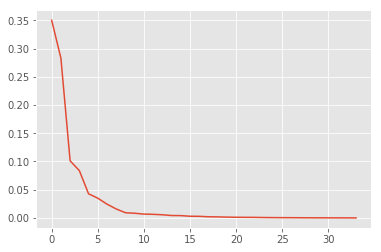

In [17]:
plt.plot(pca.explained_variance_ratios)


Atribut `pca.cov` je, jasno, kovarijacijska matrica (dvodimenzionalni `numpy.ndarray`) kojoj je na mjestu $ \left( i , j \right) $ kovarijanca $ i $-tog i $ j $-tog stupca analizirane tablice.


In [18]:
pca.cov


array([[1.        , 0.47402715, 0.48043201, 0.30732556, 0.19009511],
       [0.47402715, 1.        , 0.46997448, 0.24595426, 0.15507563],
       [0.48043201, 0.46997448, 1.        , 0.53366735, 0.3898023 ],
       [0.30732556, 0.24595426, 0.53366735, 1.        , 0.45821829],
       [0.19009511, 0.15507563, 0.3898023 , 0.45821829, 1.        ]])

Za pregled ostalih atributa čitatelja upućujem u čitanje dokumentacije klase `RS_PCA` i spomenute literature.


Od glavnih komponenti promotrit ćemo samo prvih $ n_{\text{first}} \in \mathbb{N} $ za neki takav broj po volji (ali, naravno, najviše $ K $ gdje $ K $ ima značenje kao u objašnjnju atributa `pca.shape`).


In [19]:
n_first = 2


Atribut `pca.components` matrica je (dvodimenzionalni `numpy.ndarray`) čiji su stupci koordinate normiranih vektora smjerova u prostoru $ \mathbb{R}^{K} $ (vidi objašnjenje atributa `pca.shape`) glavnih komponenti. Naravno, redoslijed stupaca usuglašen je s atributima `pca.explained_variance` i `pca.explained_variance_ratios`.


In [20]:
pca.components[:, :n_first]


array([[ 3.07095379e-01,  2.12068325e-01],
       [-5.34512557e-02,  3.77536893e-01],
       [-1.98453457e-02,  6.12114070e-03],
       [ 2.00012789e-02,  4.35013704e-03],
       [-3.24656157e-02, -9.01797766e-02],
       [-3.27443759e-02, -1.05852532e-01],
       [-4.03344170e-02, -1.21542414e-01],
       [ 2.64919828e-01,  6.58540224e-01],
       [ 1.06499552e-02, -1.33440178e-02],
       [ 1.08479192e-02, -1.57236973e-02],
       [ 1.35731083e-02, -2.32132600e-02],
       [-2.80520283e-02,  3.70339218e-02],
       [-1.97434259e-02, -2.65400266e-02],
       [-1.40968621e-02, -3.99900377e-02],
       [ 3.20661508e-01,  1.99134200e-01],
       [ 3.00311461e-02, -1.55829209e-02],
       [ 9.41014797e-03, -3.21517385e-02],
       [ 1.72577758e-02, -2.87552254e-02],
       [ 1.66172494e-02, -3.74733361e-02],
       [ 5.91822357e-02, -5.57650367e-04],
       [ 1.65710619e-02, -3.90645191e-02],
       [ 5.19267996e-02, -2.67333502e-02],
       [ 3.54295123e-02, -3.91401472e-02],
       [ 4.

Glavne komponente možemo lako i reinterpretirati metodom `pca.reinterpret`. Budući da smo promotrili samo prvih $ n_{\text{first}} $ glavnih komponenti, toliko ćemo ih i reinterpretirati (ako ne zadamo nijedan argument, ili kao argument proslijedimo `None`, reinterpretiraju se sve komponente). Povratna vrijednost te metode su matrica (dvodimenzionalni `numpy.ndarray`) i tablica `pandas.DataFrame`): koordinate promotrenih vektora smjerova u bazama vektora $ \mathbf{c} $ (vidi literaturu spomenutu na početku bilježnice) jer se baze vektora $ \mathbf{d} $ mogu lako dobiti iz baza vektora $ \mathbf{c} $, lakše nego obratno. Logično, mjesta $ \left( i , j \right) $ povratne matrice i povratne tablice usuglašena su: matrica daje koeficijent, a tablica objašnjava kojoj kategoričkoj vrijednosti odgovara vektor baze na koji se taj koeficijent odnosi.


In [21]:
coeff, values = pca.reinterpret(n_first)


Budući da nam nije toliko bitna prava reprezentacija vektora smjerova u bazi, nego nas zanimaju utjecaji kategorija i njihovih vrijednosti na glavne komponente, normirajmo stupce matrice `coeff` s obzirom na normu-$ \infty $ (dodatno, po potrebi, zamijenimo orijentaciju stupaca tako da apsolutno najveći koeficijent bude pozitivan).


In [22]:
with warnings.catch_warnings():
    warnings.filterwarnings('error')
    with np.errstate(invalid = 'raise'):
        for i in range(n_first):
            j = 0

            abs_coeff = np.abs(coeff[:, i])

            J = np.where(abs_coeff == abs_coeff.max())

            try:
                j = J[0][0]
            except IndexError:
                pass

            del J

            del abs_coeff

            if (
                coeff[j, i]
                    if np.abs(coeff[j, i].real) >= np.abs(coeff[j, i].imag)
                    else coeff[j, i].imag
            ) < 0:
                coeff[:, i] = -coeff[:, i]

            try:
                coeff[:, i] /= coeff[j, i]
            except RuntimeWarning:
                coeff[:, i] = 0

            del j

        try:
            del i
        except (NameError, UnboundLocalError):
            pass


Proučimo sada reinterpretaciju.


In [23]:
coeff


array([[ 4.79683003e-01, -5.71175128e-01],
       [ 4.23646946e-01, -5.63216471e-01],
       [ 4.11135815e-01, -5.57497406e-01],
       [ 3.76312419e-01, -1.16244790e-01],
       [ 4.16687712e-01,  1.00000000e+00],
       [ 3.72276169e-01,  7.51664635e-02],
       [ 3.70370844e-01,  4.93373982e-03],
       [ 3.69374078e-01,  3.74721159e-03],
       [ 3.67500574e-01,  1.77538672e-03],
       [ 3.67337835e-01,  1.20939595e-03],
       [ 3.65205599e-01,  6.88037522e-04],
       [ 3.64240162e-01,  3.43883075e-04],
       [ 7.61125543e-01,  5.90815548e-01],
       [ 4.46269195e-01,  3.32716791e-01],
       [ 4.37501395e-01,  5.40665081e-02],
       [ 4.36487482e-01,  2.37448610e-02],
       [ 4.35954933e-01,  2.25389296e-02],
       [ 4.35927838e-01,  1.87129221e-02],
       [ 4.35876058e-01,  1.84640684e-02],
       [ 4.35159395e-01,  1.09255003e-02],
       [ 4.35141698e-01,  8.94581354e-03],
       [ 4.35014571e-01,  4.76269129e-03],
       [ 4.34243535e-01,  3.26531731e-03],
       [ 4.

In [24]:
values


,0,1
"(0, VALUTA, 0)",2,5
"(0, VALUTA, 1)",3,4
"(0, VALUTA, 2)",5,3
"(0, VALUTA, 3)",4,1
"(1, VRSTA_KLIJENTA, 0)",1550,1410
"(1, VRSTA_KLIJENTA, 1)",1110,1550
"(1, VRSTA_KLIJENTA, 2)",1320,1110
"(1, VRSTA_KLIJENTA, 3)",1510,1610
"(1, VRSTA_KLIJENTA, 4)",1430,1430
"(1, VRSTA_KLIJENTA, 5)",1120,1320


Konačno, proučimo i rezultantne glavne komponente, to jest, koliko uistinu vidljivo diferenciraju podatke. U tu svrhu, definirajmo $ N_{\text{sample}} \in \mathbb{N} $ (najviše $ N $) koliko ćemo redaka iz tablice `cat_df` prikazati.


In [25]:
N_sample = 50


Pozivom metode `pca.transform` nad tablicom (usuglašenih stupaca kao tablica nad kojom se pozivao `pca.fit`) dohvaćaju se koordinate redaka te tablice, koji su kategoričkih vrijednosti, u koordinatnom sustavu glavnih komponenti. Drugi argument je ekvivalentan (pa i njegova opcionalnost) kao u metodi `pca.reinterpret`, ali opet uzimamo projekciju samo na prvih $ n_{\text{first}} $ komponenti jer smo samo njih proučili pa graf možemo lakše tumačiti.

Povratna matrica (dvodimenzionalni `numpy.ndarray`) ima isti broj redaka kao originalna tablica (ako ona nije sadržavala retke s nedefiniranim vrijednostima), a broj stupaca odgovara broju glavnih komponenti na koje smo podatke projicirali. U tom smislu redak dane tablice odgovara retku povratne matrice &mdash; odnose se na istu opservaciju.


In [26]:
Y = pca.transform(df.sample(N_sample), n_first)


In [27]:
Y.shape


Konačno, prikažimo rezultantnu transformaciju na grafu.


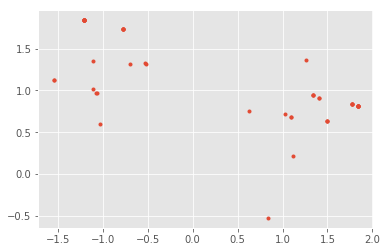

In [28]:
plt.plot(Y[:, 0], Y[:, 1], marker = '.', linestyle = 'None')


Iz grafa se nazire grupiranje podataka, ali nije evidentno koji podatci su, s obzirom na originalne kategoričke vrijednosti, *zajedno*, a koji su razmaknuti.

**Zadatak.** Odgonetnite razloge grupacija podataka na grafu i prikažite graf na kojemu su grupacije, s obzirom na originalne kategoričke vrijednosti, a ne na euklidske udaljenosti njihovih projekcija na glavne komponente, obojane različitim bojama (točke koje pripadaju istoj grupaciji neka budu obojane istom bojom, ali neka su boje po grupacijama različite). <br>
Uputa: koristite varijable `coeff` i `values`.
